# EMISSOR chat bot with audio backend

### UNDER CONSTRUCTION 

## Running with ASR

In [1]:
import requests
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from cltl.asr.speechbrain_asr import SpeechbrainASR
from cltl.asr.wav2vec_asr import Wav2Vec2ASR
from cltl.backend.api.camera import CameraResolution 
from cltl.backend.source.pyaudio_source import PyAudioSource
from cltl.backend.source.cv2_source import SystemImageSource
from cltl.backend.source.client_source import ClientAudioSource, ClientImageSource
from cltl.vad.webrtc_vad import WebRtcVAD

from cltl.backend.api.util import raw_frames_to_np

In [2]:
run_remote = True

audio_source = ClientAudioSource("http://192.168.1.176:8000/audio") if run_remote else PyAudioSource(16000, 1, 480)
image_source = ClientImageSource("http://192.168.1.176:8000/video") if run_remote else SystemImageSource(CameraResolution.QVGA)


# Add a `storage` directory to store audio files to VAD or ASR for debugging
vad = WebRtcVAD(allow_gap=250, padding=5, storage="./audio")
asr=Wav2Vec2ASR("jonatasgrosman/wav2vec2-large-xlsr-53-english", 16000, storage="./audio")
# asr = SpeechbrainASR(model_id="speechbrain/asr-transformer-transformerlm-librispeech", sampling_rate=16000, storage="./audio")

    
def detect_and_transcribe():
    text = ""
    image = None
    with audio_source as audio:
        frames = raw_frames_to_np(audio, audio_source.frame_size, audio_source.channels, audio_source.depth)

        print("Listening")
        speech, offset, consumed = tuple(vad.detect_vad(frames, audio_source.rate))
        print("Voice activity detected")

        text = asr.speech_to_text(np.concatenate(tuple(speech)), audio_source.rate)
        
    with image_source as img_src:
        image = img_src.capture()


    return text, image

In [28]:
for _ in range(5):
    print("Please talk to calibrate Voice Activity Detection")
    try:
        detect_and_transcribe()
    except Exception as e:
        print("Failed", e)

print("Calibrated VAD")

Please talk to calibrate Voice Activity Detection
Listening
Voice activity detected
Please talk to calibrate Voice Activity Detection
Listening


KeyboardInterrupt: 

Listening
Voice activity detected
Detected text: HERE WE ARE AGAIN
Captured image: (240, 320, 3)


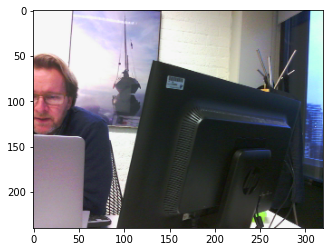

Listening
Voice activity detected
Detected text: YES  HERE AGAIN I AM HERE AGAIN
Captured image: (240, 320, 3)


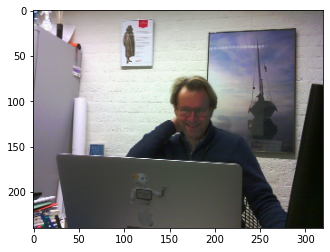

Listening
Voice activity detected
Detected text: YES THAT'S WHAT I SAID
Captured image: (240, 320, 3)


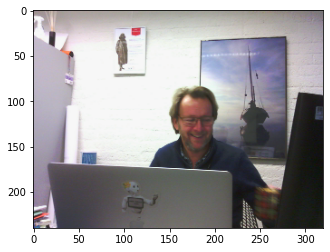

Listening
Voice activity detected


KeyboardInterrupt: 

In [3]:
tts_headers = {'Content-type': 'text/plain'}

while True:
    try:
        text, image = detect_and_transcribe()
        print("Detected text:", text)
        
        print("Captured image:", image.image.shape)
        plt.imshow(image.image)
        plt.show()
        
        if run_remote:
            requests.post("http://192.168.1.176:8000/text", data=f"Did you say {text}?", headers=tts_headers)
    except Exception as e:
        print("Failed", e)
        raise e

In [12]:
import requests
tts_headers = {'Content-type': 'text/plain'}
for _ in range(3):
    #\\^startTag({1}){0}^stopTag({1})
    response = '\\^startTag(yoo-hoo)Hello stranger!^stopTag(yoo-hoo)'
    requests.post("http://192.168.1.176:8000/text", data=response, headers=tts_headers)
    #requests.post("http://192.168.1.176:8000/text", data="Hello stranger!", headers=tts_headers)